In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [76]:
def load_data(paths, min_volume=None, max_volume=None):
    """
    Load data from CSV files and filter based on minimum and maximum cell volume.

    Parameters:
    paths (dict): A dictionary where the keys are names for the data frames, and the values are paths to CSV files.
    min_volume (float): The minimum cell volume. If None, no minimum volume constraint will be applied.
    max_volume (float): The maximum cell volume. If None, no maximum volume constraint will be applied.

    Returns:
    A dictionary containing the loaded and filtered data frames.
    """
    data_frames = {}

    for key, path in paths.items():
        try:
            df = pd.read_csv(path)
            # Select numeric columns only
            df = df.select_dtypes(include=np.number)
            
            # If a minimum volume is specified, filter the data frame based on it
            if min_volume is not None and 'cell_volume' in df.columns:
                df = df[df['cell_volume'] >= min_volume]
            
            # If a maximum volume is specified, filter the data frame based on it
            if max_volume is not None and 'cell_volume' in df.columns:
                df = df[df['cell_volume'] <= max_volume]

            data_frames[key] = df
        except Exception as e:
            print(f"Error loading data from {path}: {str(e)}")

    return data_frames


csv_files_dict = {
    'Control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    'Antanas_control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Antanas_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',

    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}
data_frames = load_data(csv_files_dict, min_volume=300, max_volume=10000)


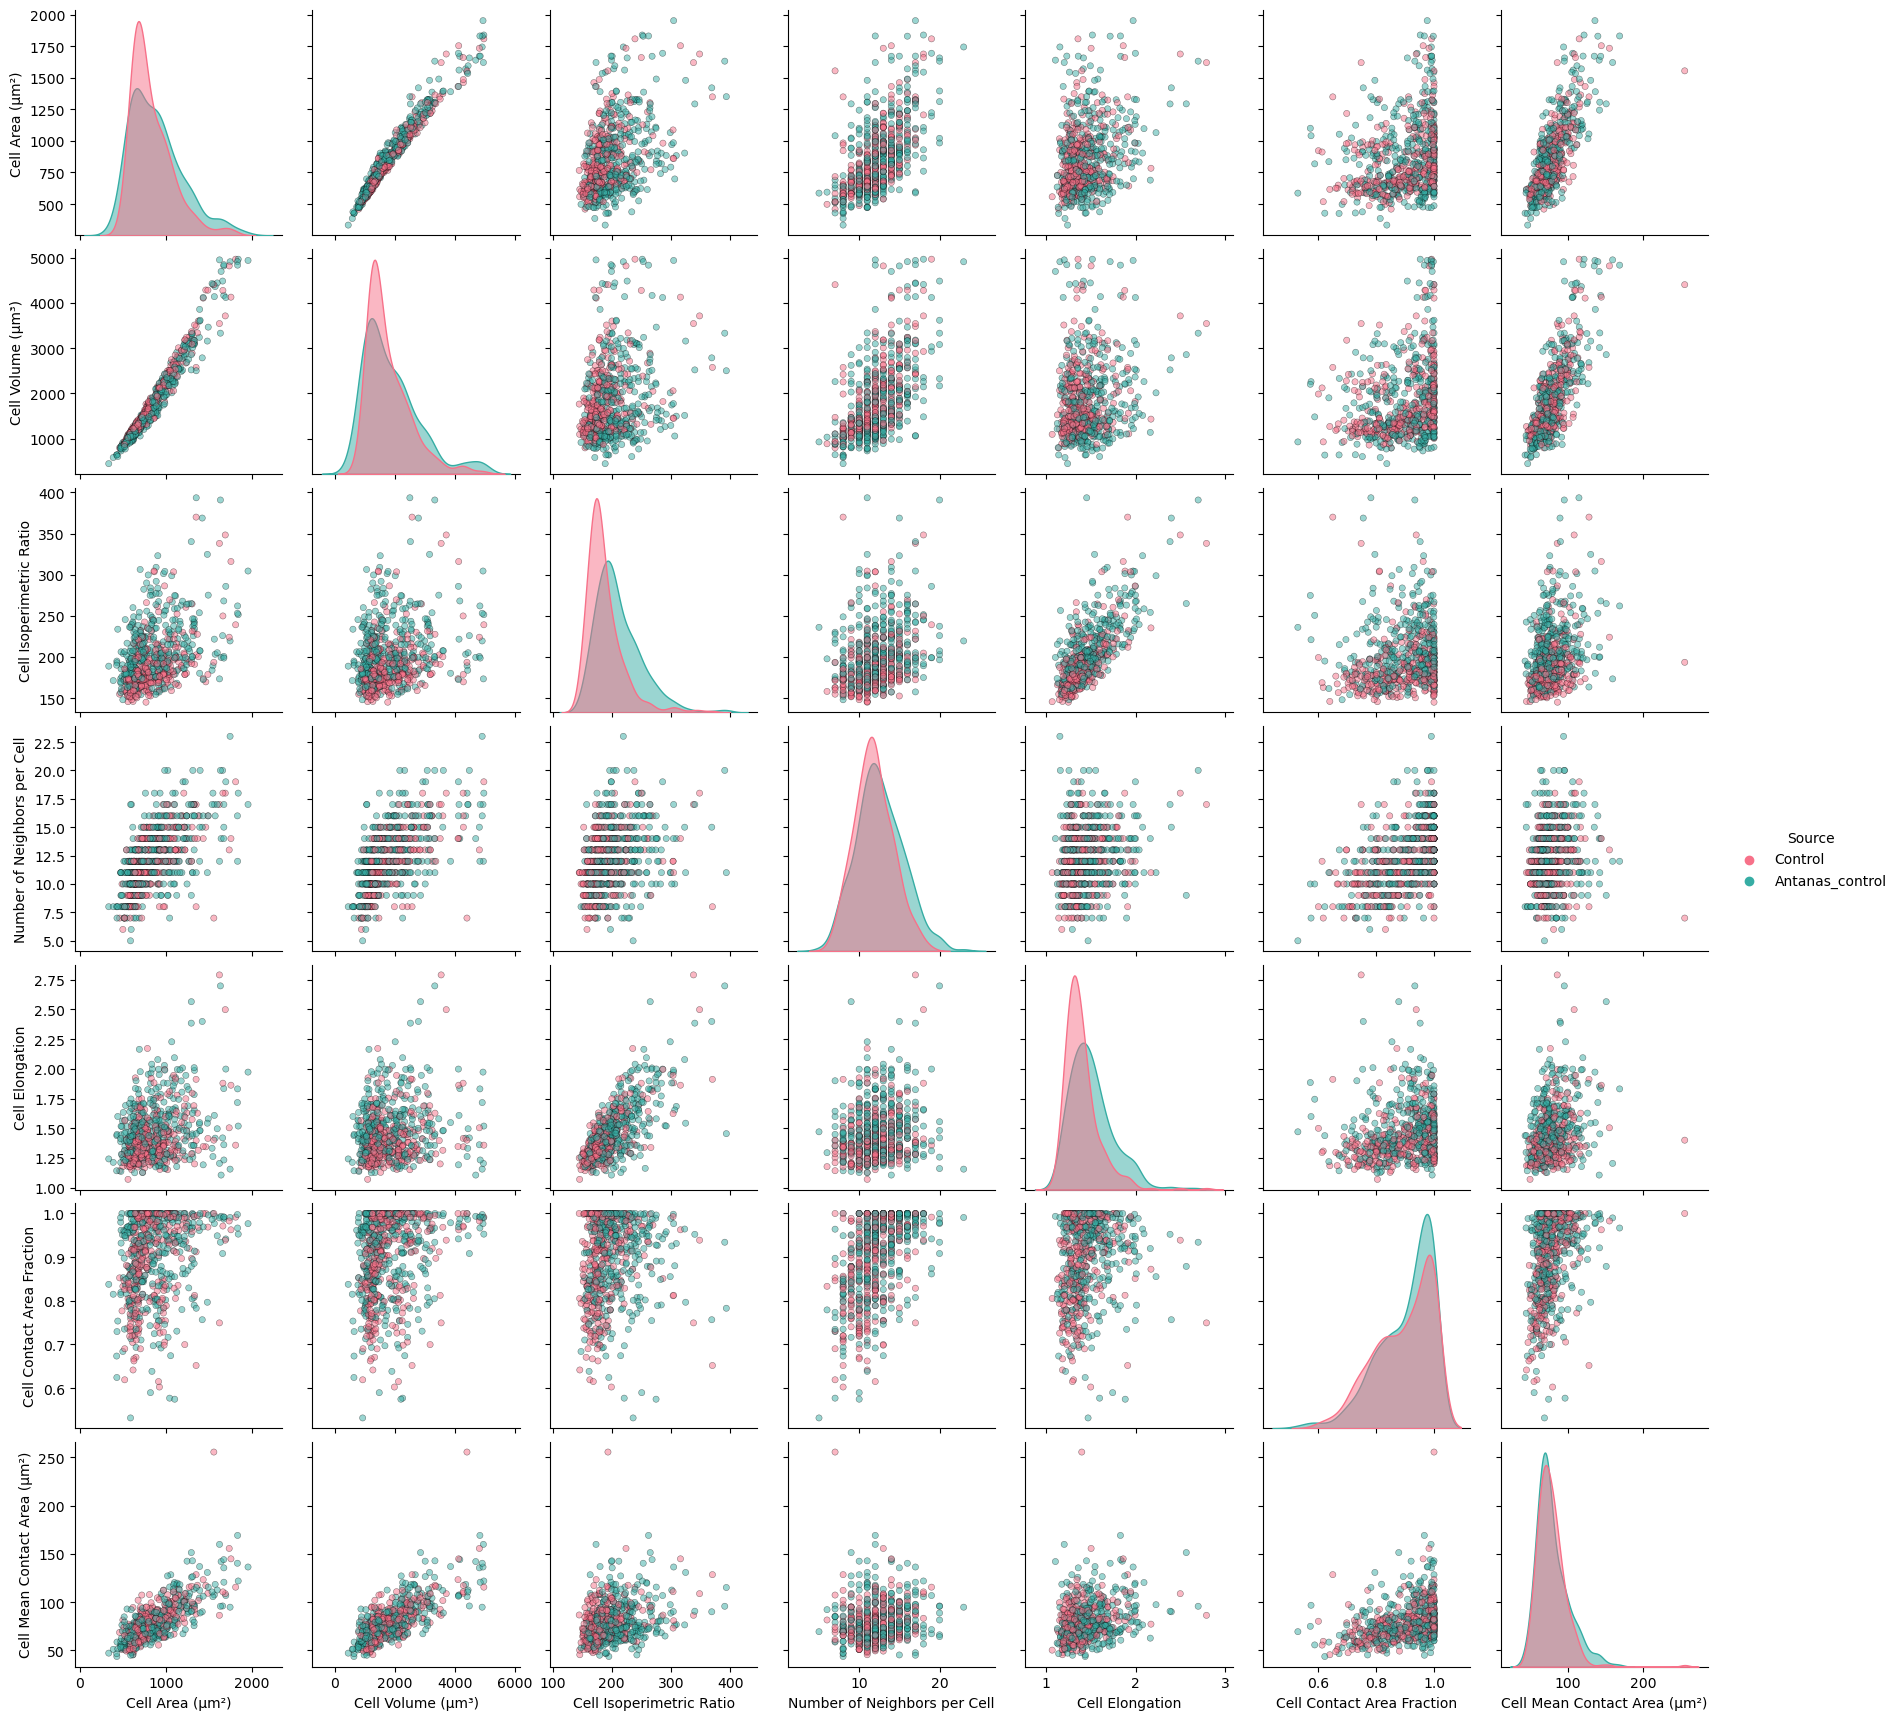

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def combine_dataframes(data_frames):
    combined = pd.DataFrame()
    for key, df in data_frames.items():
        df_temp = df.copy()  # To avoid modifying original dataframes
        df_temp['Source'] = key  # Add source column
        combined = pd.concat([combined, df_temp])
    return combined

def generate_combined_pairwise_plot(data_frames, axis_labels, lower_volume_threshold=0, upper_volume_threshold=None):
    combined = combine_dataframes(data_frames)
    
    # Drop 'cell_id' column if it exists
    if 'cell_id' in combined.columns:
        combined = combined.drop(columns='cell_id')

    # Filter for cell_volume within certain thresholds
    if 'cell_volume' in combined.columns:
        combined = combined[combined['cell_volume'] > lower_volume_threshold]
        if upper_volume_threshold is not None:
            combined = combined[combined['cell_volume'] < upper_volume_threshold]

    # Changing drawing order
    combined = combined.sample(frac=1).reset_index(drop=True)

    # Rename columns as per axis_labels
    combined.rename(columns=axis_labels, inplace=True)

    # Pairplot with hue='Source'
    sns.pairplot(combined, hue='Source', diag_kind='kde', palette='husl',
                 plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'k'},
                 diag_kws={'alpha': 0.5})
    plt.show()


axis_labels = {
    'cell_area': 'Cell Area (µm²)',
    'cell_volume': 'Cell Volume (µm³)',
    'cell_isoperimetric_ratio': 'Cell Isoperimetric Ratio',
    'cell_nb_of_neighbors': 'Number of Neighbors per Cell',
    'cell_elongation': 'Cell Elongation',
    'cell_contact_area_fraction': 'Cell Contact Area Fraction',
    'cell_mean_contact_area': 'Cell Mean Contact Area (µm²)'
}
# Assuming data_frames is your dictionary of dataframes
generate_combined_pairwise_plot(data_frames, axis_labels, lower_volume_threshold=400, upper_volume_threshold=None)

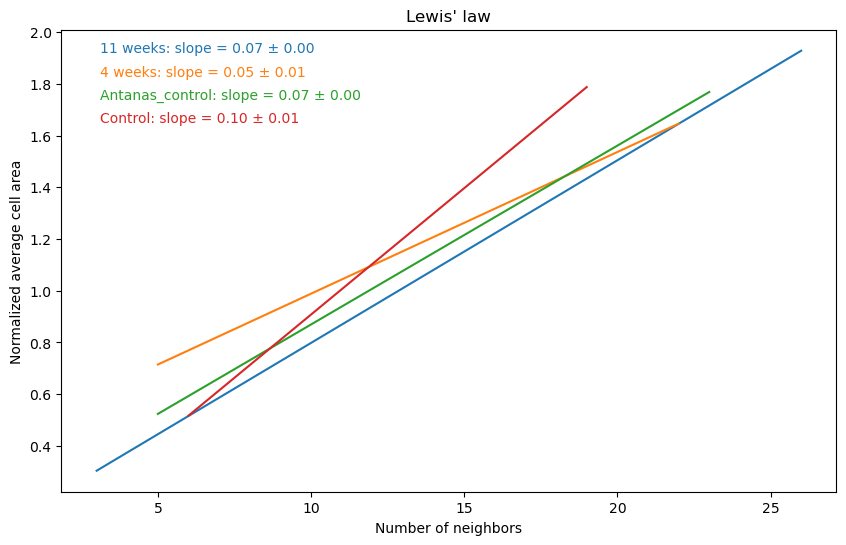

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

def plot_lewis_law_all(data_frames, min_area=0, min_volume=None, max_volume=None):
    """
    Plot Lewis' law for all data frames in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have columns 'num_neighbors', 'cell_area', and 'cell_volume'.
    min_area (float): The minimum cell area threshold.
    min_volume (float): The minimum cell volume threshold.
    max_volume (float): The maximum cell volume threshold.

    Returns:
    None
    """
    # Create an empty DataFrame for the plot
    plot_df = pd.DataFrame(columns=['num_neighbors', 'normalized_avg_area', 'Source'])
    fit_df = pd.DataFrame(columns=['num_neighbors', 'normalized_avg_area', 'Source'])  # For line fitting

    # Markers to use
    markers = ['o', 'v', 's', 'D', 'X', 'P', '*']

    # Iterate over data frames in the dictionary
    for key, df in data_frames.items():
        # Filter cells based on minimum area and volume constraints
        df = df[df['cell_area'] > min_area]
        if min_volume is not None:
            df = df[df['cell_volume'] > min_volume]
        if max_volume is not None:
            df = df[df['cell_volume'] < max_volume]

        # Calculate average area for each number of neighbours
        avg_areas = df.groupby('cell_nb_of_neighbors')['cell_area'].mean()

        # Divide by the total average area
        avg_areas /= df['cell_area'].mean()

        # Create a temporary DataFrame for the current dataset
        temp_df = avg_areas.reset_index()
        temp_df.columns = ['num_neighbors', 'normalized_avg_area']
        temp_df['Source'] = key  # Add source column for the legend

        # Append the temporary DataFrame to the fit DataFrame
        fit_df = pd.concat([fit_df, temp_df])

        # Now add the individual points to the plot DataFrame
        individual_df = df.copy()
        individual_df['normalized_avg_area'] = individual_df['cell_area'] / df['cell_area'].mean()
        individual_df.rename(columns={'cell_nb_of_neighbors': 'num_neighbors'}, inplace=True)
        individual_df['Source'] = key  # Add source column for the legend

        plot_df = pd.concat([plot_df, individual_df[['num_neighbors', 'normalized_avg_area', 'Source']]])

    # Remove any rows with NaN values
    plot_df = plot_df.dropna()
    fit_df = fit_df.dropna()

    # Convert columns to the appropriate type
    plot_df['num_neighbors'] = plot_df['num_neighbors'].astype(float)
    plot_df['normalized_avg_area'] = plot_df['normalized_avg_area'].astype(float)

    # Convert columns to numeric types for fit_df
    fit_df['num_neighbors'] = pd.to_numeric(fit_df['num_neighbors'])
    fit_df['normalized_avg_area'] = pd.to_numeric(fit_df['normalized_avg_area'])

    plt.figure(figsize=(10, 6))  # Increase plot size

    # Create the scatter plot for individual points
    sns.scatterplot(data=plot_df, x='num_neighbors', y='normalized_avg_area', hue='Source', style='Source', markers=markers[:len(data_frames)], alpha=0.7, legend=False)
    
    # Get the color palette used by seaborn
    palette = sns.color_palette(n_colors=len(data_frames))
    
    # Now add the lines fitted on averages
    for i, (key, group) in enumerate(fit_df.groupby('Source')):
        slope, intercept, r_value, p_value, std_err = stats.linregress(group['num_neighbors'], group['normalized_avg_area'])
        x_values = np.linspace(group['num_neighbors'].min(), group['num_neighbors'].max(), 100)
        y_values = intercept + slope * x_values
        plt.plot(x_values, y_values, color=palette[i])  # Make the line color the same as the points
        # Show slope and 1 standard deviation interval
        plt.text(0.05, 0.95 - i * 0.05, f'{key}: slope = {slope:.2f} ± {std_err:.2f}', transform=plt.gca().transAxes, color=palette[i])
    
    plt.xlabel('Number of neighbors')
    plt.ylabel('Normalized average cell area')
    plt.title("Lewis' law")

    plt.show()







# To call the function, you can use
# plot_lewis_law_all(data_frames, min_area=50)


# To call the function, you can use
# plot_lewis_law_all(data_frames, min_area=50)


# To call the function, you can use
# plot_lewis_law_all(data_frames, min_area=50)


plot_lewis_law_all(data_frames, min_area=0, min_volume=300, max_volume=10000)


# To call the function, you can use
# plot_lewis_law_all(data_frames)


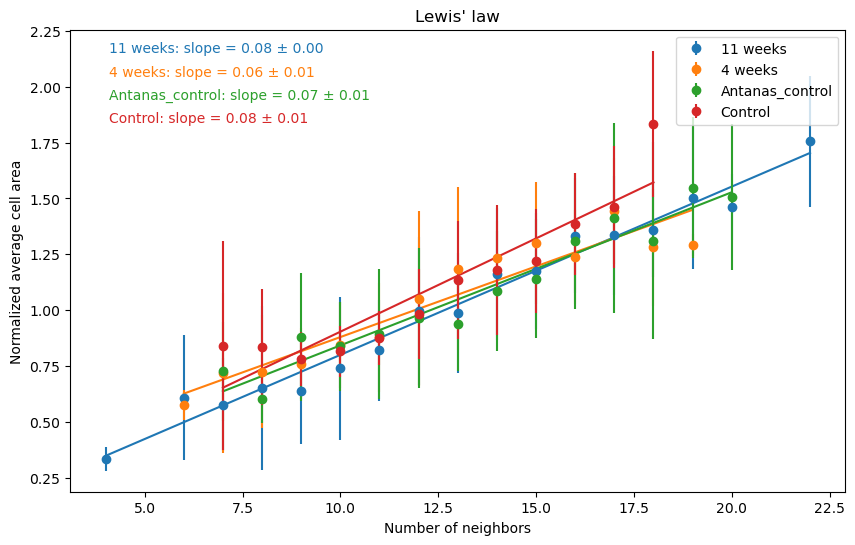

In [114]:
def plot_lewis_law_all(data_frames, min_area=0, min_volume=None, max_volume=None):
    """
    Plot Lewis' law for all data frames in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have columns 'num_neighbors', 'cell_area', and 'cell_volume'.
    min_area (float): The minimum cell area threshold.
    min_volume (float): The minimum cell volume threshold.
    max_volume (float): The maximum cell volume threshold.

    Returns:
    None
    """
    # Create an empty DataFrame for the plot
    avg_df = pd.DataFrame(columns=['num_neighbors', 'normalized_avg_area', 'std_dev', 'Source'])  # For averages and standard deviations

    # Iterate over data frames in the dictionary
    for key, df in data_frames.items():
        # Filter cells based on minimum area and volume constraints
        df = df[df['cell_area'] > min_area]
        if min_volume is not None:
            df = df[df['cell_volume'] > min_volume]
        if max_volume is not None:
            df = df[df['cell_volume'] < max_volume]

        # Calculate average area and standard deviation for each number of neighbours
        avg_areas = df.groupby('cell_nb_of_neighbors')['cell_area'].mean()
        std_devs = df.groupby('cell_nb_of_neighbors')['cell_area'].std()

        # Normalize by the total average area
        avg_areas /= df['cell_area'].mean()
        std_devs /= df['cell_area'].mean()

        # Create a temporary DataFrame for the current dataset
        temp_df = pd.concat([avg_areas, std_devs], axis=1).reset_index()
        temp_df.columns = ['num_neighbors', 'normalized_avg_area', 'std_dev']
        temp_df['Source'] = key  # Add source column for the legend

        # Append the temporary DataFrame to the averages DataFrame
        avg_df = pd.concat([avg_df, temp_df])

    # Remove any rows with NaN values
    avg_df = avg_df.dropna()

    # Convert columns to the appropriate type
    avg_df['num_neighbors'] = avg_df['num_neighbors'].astype(float)
    avg_df['normalized_avg_area'] = avg_df['normalized_avg_area'].astype(float)
    avg_df['std_dev'] = avg_df['std_dev'].astype(float)

    plt.figure(figsize=(10, 6))  # Increase plot size

    # Get the color palette used by seaborn
    palette = sns.color_palette(n_colors=len(data_frames))

    # Create the scatter plot for averages with error bars and plot linear fit
    for i, (key, group) in enumerate(avg_df.groupby('Source')):
        plt.errorbar(group['num_neighbors'], group['normalized_avg_area'], yerr=group['std_dev'], fmt='o', color=palette[i], label=key)

        # Fit a line to the data
        slope, intercept, r_value, p_value, std_err = stats.linregress(group['num_neighbors'], group['normalized_avg_area'])
        x_values = np.linspace(group['num_neighbors'].min(), group['num_neighbors'].max(), 100)
        y_values = intercept + slope * x_values
        plt.plot(x_values, y_values, color=palette[i])  # Make the line color the same as the points
        
        # Show slope and 1 standard deviation interval
        plt.text(0.05, 0.95 - i * 0.05, f'{key}: slope = {slope:.2f} ± {std_err:.2f}', transform=plt.gca().transAxes, color=palette[i])

    plt.xlabel('Number of neighbors')
    plt.ylabel('Normalized average cell area')
    plt.title("Lewis' law")
    plt.legend()

    plt.show()


plot_lewis_law_all(data_frames, min_area=0, min_volume=300, max_volume=15000)


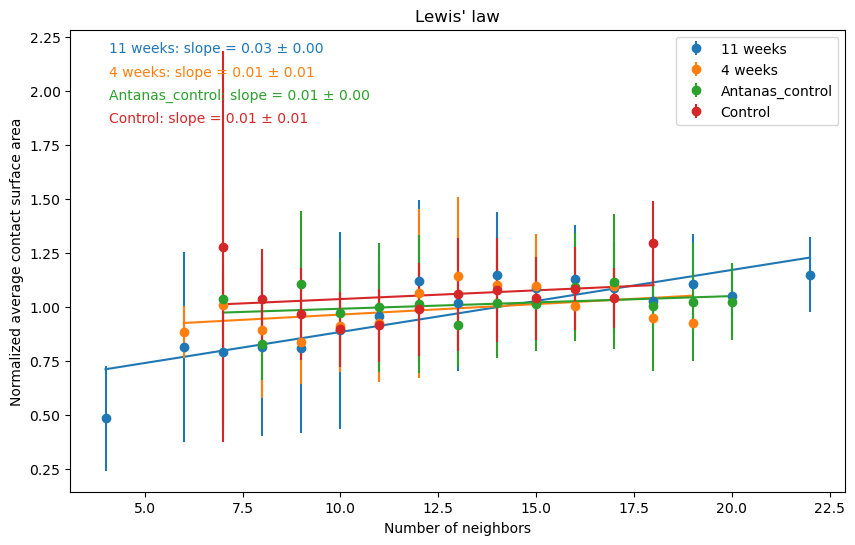

In [117]:
def plot_lewis_law_all(data_frames, min_area=0, min_volume=None, max_volume=None):
    """
    Plot Lewis' law for all data frames in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have columns 'num_neighbors', 'contact_surface_area', and 'cell_volume'.
    min_area (float): The minimum cell area threshold.
    min_volume (float): The minimum cell volume threshold.
    max_volume (float): The maximum cell volume threshold.

    Returns:
    None
    """
    # Create an empty DataFrame for the plot
    avg_df = pd.DataFrame(columns=['num_neighbors', 'normalized_avg_area', 'std_dev', 'Source'])  # For averages and standard deviations

    # Iterate over data frames in the dictionary
    for key, df in data_frames.items():
        # Filter cells based on minimum area and volume constraints
        df = df[df['cell_mean_contact_area'] > min_area]
        if min_volume is not None:
            df = df[df['cell_volume'] > min_volume]
        if max_volume is not None:
            df = df[df['cell_volume'] < max_volume]

        # Calculate average contact surface area and standard deviation for each number of neighbours
        avg_areas = df.groupby('cell_nb_of_neighbors')['cell_mean_contact_area'].mean()
        std_devs = df.groupby('cell_nb_of_neighbors')['cell_mean_contact_area'].std()

        # Normalize by the total average contact surface area
        avg_areas /= df['cell_mean_contact_area'].mean()
        std_devs /= df['cell_mean_contact_area'].mean()

        # Create a temporary DataFrame for the current dataset
        temp_df = pd.concat([avg_areas, std_devs], axis=1).reset_index()
        temp_df.columns = ['num_neighbors', 'normalized_avg_area', 'std_dev']
        temp_df['Source'] = key  # Add source column for the legend

        # Append the temporary DataFrame to the averages DataFrame
        avg_df = pd.concat([avg_df, temp_df])

    # Remove any rows with NaN values
    avg_df = avg_df.dropna()

    # Convert columns to the appropriate type
    avg_df['num_neighbors'] = avg_df['num_neighbors'].astype(float)
    avg_df['normalized_avg_area'] = avg_df['normalized_avg_area'].astype(float)
    avg_df['std_dev'] = avg_df['std_dev'].astype(float)

    plt.figure(figsize=(10, 6))  # Increase plot size

    # Get the color palette used by seaborn
    palette = sns.color_palette(n_colors=len(data_frames))

    # Create the scatter plot for averages with error bars and plot linear fit
    for i, (key, group) in enumerate(avg_df.groupby('Source')):
        plt.errorbar(group['num_neighbors'], group['normalized_avg_area'], yerr=group['std_dev'], fmt='o', color=palette[i], label=key)

        # Fit a line to the data
        slope, intercept, r_value, p_value, std_err = stats.linregress(group['num_neighbors'], group['normalized_avg_area'])
        x_values = np.linspace(group['num_neighbors'].min(), group['num_neighbors'].max(), 100)
        y_values = intercept + slope * x_values
        plt.plot(x_values, y_values, color=palette[i])  # Make the line color the same as the points
        
        # Show slope and 1 standard deviation interval
        plt.text(0.05, 0.95 - i * 0.05, f'{key}: slope = {slope:.2f} ± {std_err:.2f}', transform=plt.gca().transAxes, color=palette[i])

    plt.xlabel('Number of neighbors')
    plt.ylabel('Normalized average contact surface area')
    plt.title("Lewis' law")
    plt.legend()

    plt.show()


plot_lewis_law_all(data_frames, min_area=0, min_volume=300, max_volume=15000)


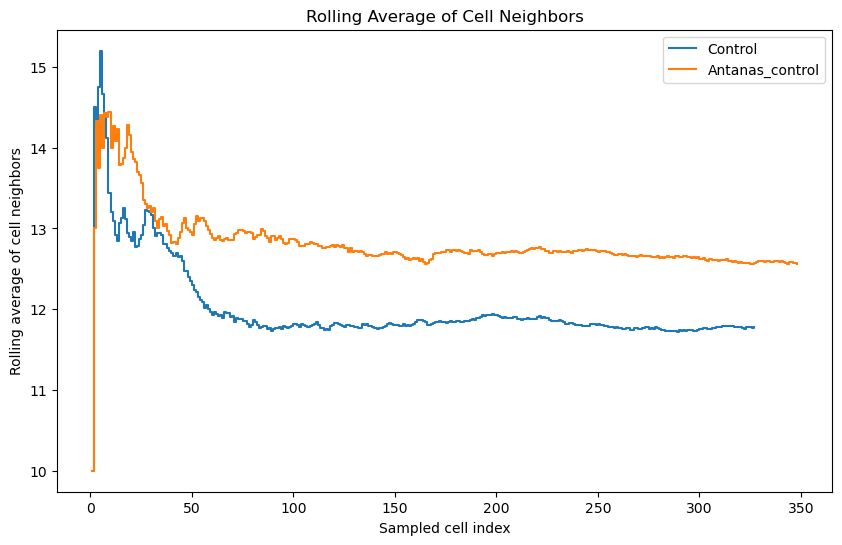

In [34]:
def plot_rolling_average(data_frames):
    """
    Plot a rolling average of cell neighbors for each data frame in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have a column 'cell_nb_of_neighbors'.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))  # Increase plot size

    # Iterate over data frames in the dictionary
    for i, (key, df) in enumerate(data_frames.items()):
        # Randomly sample cells without replacement
        df_sampled = df.sample(frac=1, replace=False).reset_index(drop=True)
        
        # Calculate rolling average of cell neighbors
        rolling_avg = df_sampled['cell_nb_of_neighbors'].expanding().mean()

        # Plot the rolling average
        plt.step(range(1, len(rolling_avg) + 1), rolling_avg, where='post', label=key)

    plt.xlabel('Sampled cell index')
    plt.ylabel('Rolling average of cell neighbors')
    plt.title('Rolling Average of Cell Neighbors')
    plt.legend()
    plt.show()


plot_rolling_average(data_frames)

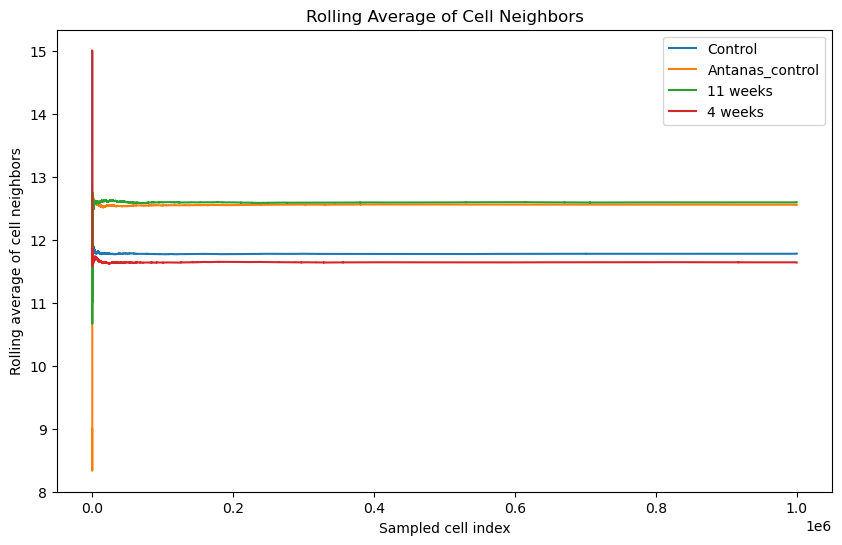

In [6]:
def plot_rolling_average(data_frames, num_samples=None):
    """
    Plot a rolling average of cell neighbors for each data frame in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have a column 'cell_nb_of_neighbors'.
    num_samples (int): The number of cells to sample from each data frame. If None, all cells will be sampled.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))  # Increase plot size

    # Iterate over data frames in the dictionary
    for i, (key, df) in enumerate(data_frames.items()):
        # If num_samples is not specified, use the size of the DataFrame
        n = num_samples if num_samples is not None else len(df)

        # Randomly sample cells with replacement
        df_sampled = df.sample(n, replace=True).reset_index(drop=True)
        
        # Calculate rolling average of cell neighbors
        rolling_avg = df_sampled['cell_nb_of_neighbors'].expanding().mean()

        # Plot the rolling average
        plt.step(range(1, len(rolling_avg) + 1), rolling_avg, where='post', label=key)

    plt.xlabel('Sampled cell index')
    plt.ylabel('Rolling average of cell neighbors')
    plt.title('Rolling Average of Cell Neighbors')
    plt.legend()
    plt.show()


plot_rolling_average(data_frames, num_samples=1000000)


{'Control':      cell_id    cell_area  cell_volume  cell_isoperimetric_ratio  \
0          1   226.392679   152.288547                500.325518   
1          2   346.779927   338.175337                364.651488   
2          3  1104.403379  2097.790705                306.096854   
3          4   364.859871   409.508191                289.636384   
4          5   237.736568   244.039479                225.614906   
..       ...          ...          ...                       ...   
602      603   399.275796   539.931156                218.344459   
603      604   315.346074   395.012292                200.974551   
604      605   600.399813   805.861748                333.273331   
605      606   433.799909   555.725484                264.330784   
606      607   215.077006   220.430966                204.756048   

    cell_neighbors  cell_nb_of_neighbors           cell_principal_axis  \
0               []                     3  5.71e-02 -5.52e-02 -9.97e-01   
1               []     

/Users/antanas/opt/anaconda3/envs/EpiStats/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


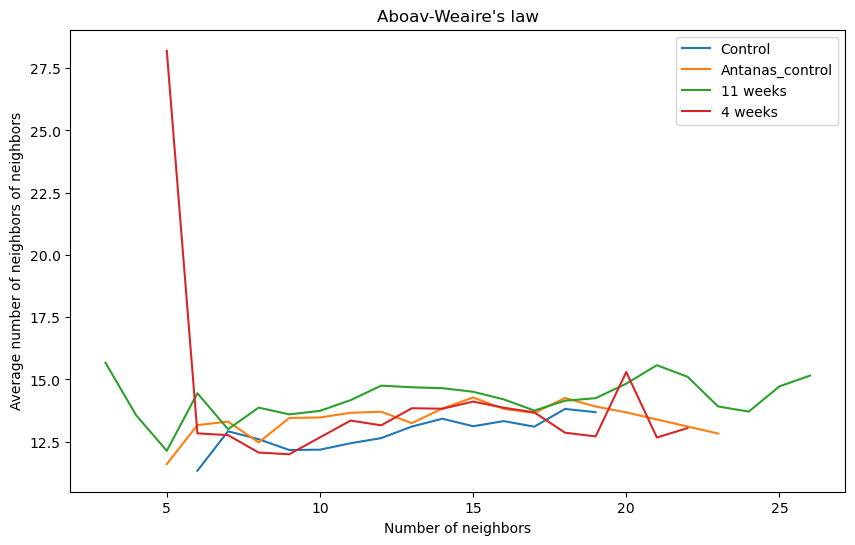

In [75]:
def load_data(paths, min_volume=None, max_volume=None):
    """
    Load data from CSV files and filter based on minimum and maximum cell volume.

    Parameters:
    paths (dict): A dictionary where the keys are names for the data frames, and the values are paths to CSV files.
    min_volume (float): The minimum cell volume. If None, no minimum volume constraint will be applied.
    max_volume (float): The maximum cell volume. If None, no maximum volume constraint will be applied.

    Returns:
    A dictionary containing the loaded and filtered data frames.
    """
    data_frames = {}

    for key, path in paths.items():
        try:
            df = pd.read_csv(path)

            # If a minimum volume is specified, filter the data frame based on it
            if min_volume is not None and 'cell_volume' in df.columns:
                df = df[df['cell_volume'] >= min_volume]
            
            # If a maximum volume is specified, filter the data frame based on it
            if max_volume is not None and 'cell_volume' in df.columns:
                df = df[df['cell_volume'] <= max_volume]

            data_frames[key] = df
        except Exception as e:
            print(f"Error loading data from {path}: {str(e)}")

    return data_frames

csv_files_dict = {
    'Control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_Control_s_10_e_2_d_3/all_cell_statistics.csv',
    'Antanas_control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Antanas_Control_s_10_e_2_d_3/all_cell_statistics.csv',

    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_11w_s_10_e_2_d_3/all_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_4w_s_10_e_2_d_3/all_cell_statistics.csv'
}

full_data_frames = load_data(csv_files_dict, min_volume=None, max_volume=None)

def extract_cell_ids(data_frames):
    """
    Extract 'cell_id' column from each dataframe in the input dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have a column 'cell_id'.

    Returns:
    cell_ids (dict): A dictionary where the keys are the same as data_frames, and the values are the 'cell_id' columns of the corresponding dataframes.
    """
    cell_ids = {}
    for key, df in data_frames.items():
        cell_ids[key] = df['cell_id'].tolist()
    return cell_ids

csv_files_dict = {
    'Control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    'Antanas_control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Antanas_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',

    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

filtered_data_frames = load_data(csv_files_dict, min_volume=None, max_volume=None)

filtered_cell_ids = extract_cell_ids(filtered_data_frames)



def plot_aboav_weaire_law(data_frames):
    """
    Plot Aboav-Weaire's law for all data frames in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have a column 'cell_id', 'cell_nb_of_neighbors' and 'cell_neighbors' which is an array.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))  # Increase plot size

    # Iterate over data frames in the dictionary
    for key, df in data_frames.items():
        # Create a dictionary of cell neighbors using cell_id as the key
        neighbor_dict = pd.Series(df.cell_nb_of_neighbors.values,index=df.cell_id).to_dict()

        # Ensure cell_neighbors is a list of integers
        df['cell_neighbors'] = df['cell_neighbors'].apply(lambda x: [int(n) for n in str(x).split()] if isinstance(x, str) else [])

        # Calculate the average number of neighbors for each cell's neighbors
        df['nn_avg'] = df['cell_neighbors'].apply(lambda x: np.mean([neighbor_dict.get(n, 0) for n in x if n in neighbor_dict]))

        # Group by the number of neighbors and calculate the average nn_avg
        grouped = df.groupby('cell_nb_of_neighbors')['nn_avg'].mean().reset_index()

        # Plot nn_avg against the number of neighbors
        plt.plot(grouped['cell_nb_of_neighbors'], grouped['nn_avg'], label=key)

    plt.xlabel('Number of neighbors')
    plt.ylabel('Average number of neighbors of neighbors')
    plt.title("Aboav-Weaire's law")
    plt.legend()
    plt.show()

def plot_aboav_weaire_law(data_frames, filtered_cell_id_dict):
    """
    Plot Aboav-Weaire's law for all data frames in a dictionary.

    Parameters:
    data_frames (dict): The dictionary containing the data frames. Each data frame must have a column 'cell_id', 'cell_nb_of_neighbors' and 'cell_neighbors' which is an array.
    filtered_cell_id_dict (dict): A dictionary containing the same keys as data_frames and lists of cell_ids that should be included in the plots.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))  # Increase plot size

    # Iterate over data frames in the dictionary
    for key, df in data_frames.items():

        # Create a dictionary of cell neighbors using cell_id as the key
        neighbor_dict = pd.Series(df.cell_nb_of_neighbors.values,index=df.cell_id).to_dict()

        # Ensure cell_neighbors is a list of integers
        df['cell_neighbors'] = df['cell_neighbors'].apply(lambda x: [int(n) for n in str(x).split()] if isinstance(x, str) else [])

        # Calculate the average number of neighbors for each cell's neighbors
        df['nn_avg'] = df['cell_neighbors'].apply(lambda x: np.mean([neighbor_dict.get(n, 0) for n in x if n in neighbor_dict]))
        print(df['nn_avg'])
        # Filter the dataframe to only include the cell_ids specified in filtered_cell_id_dict
        df = df[df['cell_id'].isin(filtered_cell_id_dict[key])]

        # Group by the number of neighbors and calculate the average nn_avg
        grouped = df.groupby('cell_nb_of_neighbors')['nn_avg'].mean().reset_index()
        # Plot nn_avg against the number of neighbors
        plt.plot(grouped['cell_nb_of_neighbors'], grouped['nn_avg'], label=key)

    plt.xlabel('Number of neighbors')
    plt.ylabel('Average number of neighbors of neighbors')
    plt.title("Aboav-Weaire's law")
    plt.legend()
    plt.show()


print(data_frames)

    
plot_aboav_weaire_law(full_data_frames, filtered_cell_id_dict=filtered_cell_ids)

In [46]:
data_frames['Control']

,cell_id,cell_area,cell_volume,cell_isoperimetric_ratio,cell_neighbors,cell_nb_of_neighbors,cell_principal_axis,cell_elongation,cell_contact_area_fraction,cell_contact_area_distribution,cell_mean_contact_area
0,31,1086.617520,2055.977055,303.524381,7 10 14 38 44 51 53 54 62 81 82 95,12,-5.73e-01 3.90e-01 7.21e-01,1.944479,0.992907,"[22.510764132947976, 67.52256990779975, 112.13...",110.775633
1,34,593.360103,938.110863,237.381405,9 13 16 17 18 19 21 35 36 46 63 592,12,3.94e-01 3.25e-01 8.60e-01,1.368656,0.942056,"[42.28090632314721, 47.498217243341585, 71.329...",59.312043
2,36,783.210900,1428.847045,235.323168,21 32 34 35 46 48 57 63 64 73 84,11,-5.75e-01 4.35e-01 6.93e-01,2.170557,0.872361,"[115.0866468124755, 53.61188640221803, 57.0135...",77.097834
3,38,922.351125,1984.205629,199.303759,10 14 31 44 61 65 82 95,8,8.66e-01 -2.17e-01 -4.51e-01,1.499425,0.602435,"[96.53412891247314, 54.24713873584037, 152.286...",80.097737
4,44,1753.049993,4128.660090,316.056441,7 10 11 14 31 38 49 51 53 61 69 81 82 90,14,8.32e-01 -4.43e-01 -3.33e-01,1.861661,0.962649,"[350.484156491867, 40.54462881412984, 46.29785...",144.865427
...,...,...,...,...,...,...,...,...,...,...,...
322,587,643.931195,1163.638481,197.188800,138 171 172 180 193 201 208 214 232 576,10,8.72e-01 -4.86e-01 5.47e-02,1.226241,0.779186,"[39.134480942918124, 50.06485154337882, 134.01...",62.814861
323,588,703.663516,1224.766584,232.267500,267 271 277 295 296 301 311 332 334,9,1.66e-02 1.72e-01 9.85e-01,1.288901,0.988927,"[223.71647432501425, 67.10726610692792, 5.3778...",95.128465
324,589,653.424930,1273.637545,171.986910,329 355 389 390 399 413 438 583,8,7.48e-01 -5.95e-01 -2.94e-01,1.349777,0.710153,"[58.33618031852826, 66.70328031478307, 81.1870...",69.110119
325,590,955.519821,2017.158901,214.406960,322 362 377 388 395 410 422 427 430 441 445 44...,16,-5.15e-01 8.53e-01 -8.70e-02,1.283788,0.847608,"[2.2678051641610306, 39.49759216615547, 63.610...",63.521512


In [35]:
import pandas as pd
from scipy import stats

def perform_t_tests(df1, df2, columns):
    """
    Performs a t-test for each specified column between two data frames.

    Parameters:
    df1, df2 (DataFrame): The data frames containing the data.
    columns (list): A list of strings representing the column names to test.

    Returns:
    dict: A dictionary containing the t-statistic and p-value for each column.
    """
    results = {}
    for col in columns:
        t_stat, p_value = stats.ttest_ind(df1[col], df2[col])
        results[col] = {"t-statistic": t_stat, "p-value": p_value}
    return results

results = perform_t_tests(data_frames['Control'], data_frames['Antanas_control'], ['cell_volume', 'cell_area', 'cell_isoperimetric_ratio', 'cell_nb_of_neighbors', 'cell_elongation', 'cell_contact_area_fraction', 'cell_mean_contact_area'])
for column, res in results.items():
    print(f"For column {column}:")
    print(f"t-statistic: {res['t-statistic']}, p-value: {res['p-value']}")


For column cell_volume:
t-statistic: -1.6125343346099748, p-value: 0.10731451564211554
For column cell_area:
t-statistic: -2.7279493975114417, p-value: 0.006539182775535021
For column cell_isoperimetric_ratio:
t-statistic: -8.530245079000519, p-value: 9.634556519284235e-17
For column cell_nb_of_neighbors:
t-statistic: -3.7706171041959617, p-value: 0.00017716139417676402
For column cell_elongation:
t-statistic: -6.499285238164537, p-value: 1.5715164039964633e-10
For column cell_contact_area_fraction:
t-statistic: -1.3821636411399896, p-value: 0.16738000606131023
For column cell_mean_contact_area:
t-statistic: -1.361545706969757, p-value: 0.17379692763098603


In [36]:
import pandas as pd
from scipy import stats

def perform_ranksum_tests(df1, df2, columns):
    """
    Performs a Wilcoxon Rank-Sum Test for each specified column between two data frames.

    Parameters:
    df1, df2 (DataFrame): The data frames containing the data.
    columns (list): A list of strings representing the column names to test.

    Returns:
    dict: A dictionary containing the z-statistic and p-value for each column.
    """
    results = {}
    for col in columns:
        z_stat, p_value = stats.ranksums(df1[col], df2[col])
        results[col] = {"z-statistic": z_stat, "p-value": p_value}
    return results

results = perform_ranksum_tests(data_frames['Antanas_control'], data_frames['Control'], ['cell_volume', 'cell_area', 'cell_isoperimetric_ratio', 'cell_nb_of_neighbors', 'cell_elongation', 'cell_contact_area_fraction', 'cell_mean_contact_area'])
for column, res in results.items():
    print(f"For column {column}:")
    print(f"z-statistic: {res['z-statistic']}, p-value: {res['p-value']}")


For column cell_volume:
z-statistic: 0.23816124332668406, p-value: 0.8117560356527126
For column cell_area:
z-statistic: 1.9325422281881677, p-value: 0.053292615189507
For column cell_isoperimetric_ratio:
z-statistic: 9.646122795634502, p-value: 5.104944027323092e-22
For column cell_nb_of_neighbors:
z-statistic: 3.444451414679953, p-value: 0.0005722194659168994
For column cell_elongation:
z-statistic: 6.911020623101687, p-value: 4.811790893992875e-12
For column cell_contact_area_fraction:
z-statistic: 0.9344767855902727, p-value: 0.3500580053128667
For column cell_mean_contact_area:
z-statistic: 0.5197681529318677, p-value: 0.6032251787684952


In [88]:
from scipy.stats import chisquare

from scipy.stats import ks_2samp

def ks_test(data1, data2):
    """
    Compute Kolmogorov-Smirnov test statistic.

    Parameters:
    data1 (array): A one-dimensional array of data.
    data2 (array): A one-dimensional array of data.

    Returns:
    ks_stat (float): KS statistic.
    p_val (float): two-tailed p-value.
    """
    ks_stat, p_val = ks_2samp(data1, data2)

    return ks_stat, p_val


ks_test(data_frames['11 weeks']['cell_nb_of_neighbors'], data_frames['Control']['cell_nb_of_neighbors'])


(0.19354039601592266, 4.350309377883814e-06)

In [113]:

from scipy.stats import chisquare

def prepare_data_for_chi_square_test(df1, df2, column_name):
    """
    Prepare data for chi-square test.

    Parameters:
    df1 (DataFrame): The first DataFrame.
    df2 (DataFrame): The second DataFrame.
    column_name (str): The column to use for calculating frequency distribution.

    Returns:
    observed_values (array): An array of observed frequency counts.
    expected_values (array): An array of expected frequency counts.
    """
    # Get the union of all unique values from both datasets
    unique_values = np.union1d(df1[column_name].unique(), df2[column_name].unique())

    # Calculate observed frequency distribution
    observed_values = df1[column_name].value_counts().reindex(unique_values, fill_value=0).values

    # Calculate expected frequency distribution
    expected_values = df2[column_name].value_counts().reindex(unique_values, fill_value=0).values

    # Find the indices of the first and last non-zero elements in both arrays
    non_zero_observed_indices = np.nonzero(observed_values)[0]
    non_zero_expected_indices = np.nonzero(expected_values)[0]
    
    first_non_zero = max(non_zero_observed_indices[0], non_zero_expected_indices[0])
    last_non_zero = min(non_zero_observed_indices[-1], non_zero_expected_indices[-1])

    # Cut the tails of both arrays to the indices of the first and last non-zero elements
    observed_values = observed_values[first_non_zero:last_non_zero+1]
    expected_values = expected_values[first_non_zero:last_non_zero+1]

    return observed_values, expected_values




from scipy.stats import chisquare

def chi_square_test(observed_values, expected_values):
    """
    Compute Chi-Square test statistic.

    Parameters:
    observed_values (array): An array of observed frequency counts.
    expected_values (array): An array of expected frequency counts.

    Returns:
    chi2_stat (float): The test statistic.
    p_val (float): The p-value of the test.
    """
    # Normalize the observed and expected values
    observed_values = observed_values / observed_values.sum()
    expected_values = expected_values / expected_values.sum()

    chi2_stat, p_val = chisquare(observed_values, f_exp=expected_values)

    return chi2_stat, p_val

observed_values, expected_values = prepare_data_for_chi_square_test(data_frames['4 weeks'], data_frames['Antanas_control'], 'cell_nb_of_neighbors')
print(expected_values[2:16])
print(observed_values[2:16])
chi_square_test(observed_values[2:16], expected_values[2:16])


[ 7 22 16 35 49 54 41 36 30 23 16  7  3  6]
[ 9 18 20 35 44 16 27 21 17  5  8  2  2  1]


(0.20875632714264797, 0.9999999997960257)

In [ ]:
data_frames['Franzi_control'].describe()

,cell_id,cell_area,cell_volume,cell_isoperimetric_ratio,cell_nb_of_neighbors,cell_elongation,cell_contact_area_fraction,cell_mean_contact_area
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,305.899083,827.137857,1776.075002,187.469027,11.779817,1.398795,0.892406,77.867014
std,151.860200,243.334589,739.402865,31.957118,2.390001,0.196862,0.100070,19.595412
min,31.000000,260.095726,303.433367,144.938918,6.000000,1.070548,0.495073,19.691638
25%,179.500000,658.423770,1255.297677,169.104922,10.000000,1.281436,0.823560,65.406763
50%,301.000000,758.296663,1522.289223,178.742164,12.000000,1.352970,0.916132,74.782597
75%,428.000000,953.831362,2135.089587,198.249838,13.000000,1.468400,0.987899,86.667693
max,598.000000,1807.371714,4968.682194,370.050041,19.000000,2.788742,1.000000,255.639761


In [ ]:
data_frames['11 weeks'].describe()

,cell_id,cell_area,cell_volume,cell_isoperimetric_ratio,cell_nb_of_neighbors,cell_elongation,cell_contact_area_fraction,cell_mean_contact_area
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,342.734247,945.510078,2139.053382,201.672553,12.600000,1.450076,0.871371,79.921903
std,194.154346,392.118605,1160.205891,38.072673,3.779499,0.212202,0.163328,28.891956
min,3.000000,193.533217,211.897416,144.265060,3.000000,1.112130,0.257755,17.101163
25%,176.000000,624.615457,1161.545944,176.208802,10.000000,1.290520,0.802402,61.365453
50%,344.000000,911.431130,1955.385831,194.640893,13.000000,1.414376,0.947196,79.497798
75%,509.000000,1228.275617,2999.336488,215.959687,15.000000,1.573475,0.997107,95.582537
max,695.000000,2008.532058,4996.123125,419.234719,26.000000,2.386527,1.000000,188.852310


In [128]:
def compute_summary_statistics(df):
    """
    Compute the mean and variance for each column in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    summary_df (DataFrame): A DataFrame containing the mean and variance for each column in df.
    """
    if 'cell_id' in df.columns:
        df = df.drop('cell_id', axis=1)
        
    summary_df = pd.DataFrame(index=['mean', 'std'], columns=df.columns)
    summary_df.loc['mean'] = df.mean()
    summary_df.loc['std'] = df.std()
    
    return summary_df

summary_statistics_dict = {key: compute_summary_statistics(df) for key, df in data_frames.items()}
summary_df = pd.concat(summary_statistics_dict, names=['Treatment', 'Statistic'])

# Define the formatting function
float_formatter = lambda x: "%.2f" % x
latex_table = summary_df.to_latex(float_format=float_formatter)



print(latex_table)

\begin{tabular}{lllllllll}
\toprule
        &     & cell\_area & cell\_volume & cell\_isoperimetric\_ratio & cell\_nb\_of\_neighbors & cell\_elongation & cell\_contact\_area\_fraction & cell\_mean\_contact\_area \\
Treatment & Statistic &           &             &                          &                      &                 &                            &                        \\
\midrule
Control & mean &    827.14 &     1776.08 &                   187.47 &                11.78 &            1.40 &                       0.89 &                  77.87 \\
        & std &    243.33 &      739.40 &                    31.96 &                 2.39 &            0.20 &                       0.10 &                  19.60 \\
Antanas\_control & mean &    885.46 &     1881.93 &                   211.00 &                12.56 &            1.51 &                       0.90 &                  80.02 \\
        & std &    306.27 &      946.27 &                    39.09 &                 2.92 &      

/var/folders/0q/4mgwbnlj0tj34_6lyhzrbs5c0000gn/T/ipykernel_7261/2491365381.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = summary_df.to_latex(float_format=float_formatter)


In [125]:
data_frames['11 weeks'].var()

cell_id                       3.760106e+04
cell_area                     1.464074e+05
cell_volume                   1.301488e+06
cell_isoperimetric_ratio      1.462253e+03
cell_nb_of_neighbors          1.364907e+01
cell_elongation               4.526417e-02
cell_contact_area_fraction    2.264380e-02
cell_mean_contact_area        7.787899e+02
dtype: float64

In [ ]:
def apply_pca(csv_path, n_components=2):
    """
    Apply PCA to the numeric columns of a CSV file.

    Parameters:
    -----------
    csv_path: str
        The path to the CSV file.

    n_components: int
        The number of principal components to compute. Default is 2.

    Returns:
    --------
    pca_results: numpy.ndarray
        The transformed data in the new coordinate system defined by the principal components.

    explained_variance_ratio: numpy.ndarray
        Percentage of variance explained by each of the selected components.
    """
    
    # Load the CSV data
    data_df = pd.read_csv(csv_path)

    # Select numeric columns only
    numeric_data_df = data_df.select_dtypes(include=np.number)

    # Standardize the numeric data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(numeric_data_df)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(standardized_data)

    return pca_results, pca.explained_variance_ratio_


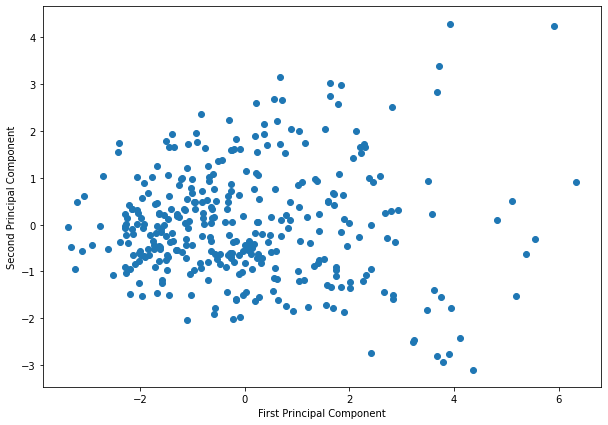

Principal Component 1: 41.54% of the variance
Principal Component 2: 18.20% of the variance


In [ ]:
import matplotlib.pyplot as plt

def apply_and_plot_pca(csv_path, n_components=2):
    """
    Apply PCA to the numeric columns of a CSV file and plot the results.

    Parameters:
    -----------
    csv_path: str
        The path to the CSV file.

    n_components: int
        The number of principal components to compute. Default is 2.
    """
    
    # Apply PCA
    pca_results, explained_variance_ratio = apply_pca(csv_path, n_components)

    # Create a plot
    plt.figure(figsize=(10, 7))

    # If we have 2 or more components, make a scatter plot of the first two components
    if n_components >= 2:
        plt.scatter(pca_results[:, 0], pca_results[:, 1])
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')

    # If we have only one component, make a line plot
    elif n_components == 1:
        plt.plot(pca_results)
        plt.xlabel('Index')
        plt.ylabel('First Principal Component')

    # Show the plot
    plt.show()

    # Print the explained variance
    for i, explained_var in enumerate(explained_variance_ratio):
        print(f'Principal Component {i + 1}: {explained_var * 100:.2f}% of the variance')

path = '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Antanas_Control_s_10_e_2_d_3/filtered_cell_statistics.csv'
apply_and_plot_pca(path, 2)

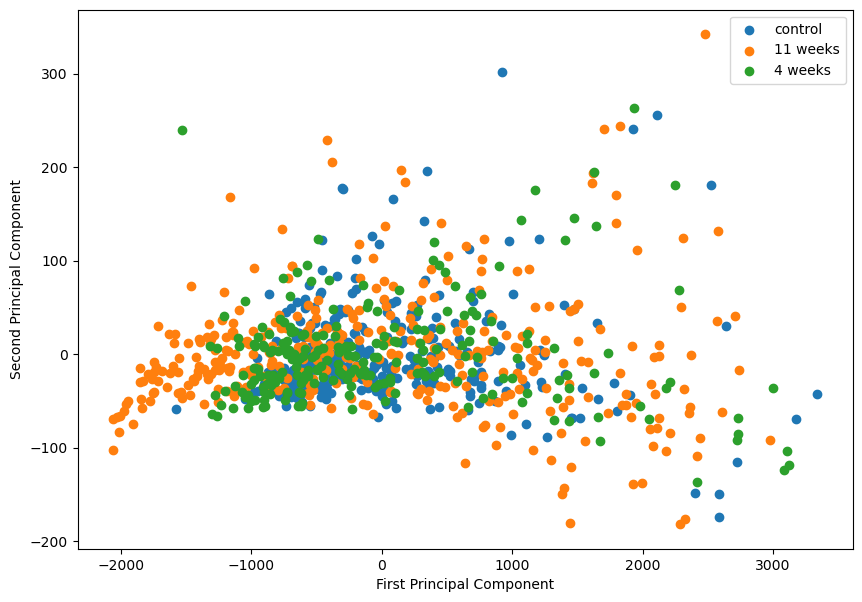

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def apply_and_plot_pca(csv_files_dict, n_components=2):
    """
    Apply PCA to multiple CSV files and plot the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_dict: dict
        A dictionary where the keys are the labels and the values are the PCA results (numpy arrays).
    """

    pca = PCA(n_components=n_components)

    # Create a plot
    plt.figure(figsize=(10, 7))

    
    pca_results_dict = {}
    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
            # Drop 'cell_id' column if it exists
        if 'cell_id' in numeric_columns.columns:
            numeric_columns = numeric_columns.drop(columns='cell_id')
        # Apply PCA
        pca_results = pca.fit_transform(numeric_columns)

        # Add the PCA results to the dictionary
        pca_results_dict[label] = pca_results

        # Plot the PCA results
        if pca_results.shape[1] >= 2:
            plt.scatter(pca_results[:, 0], pca_results[:, 1], label=label)

    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.show()

    return pca_results_dict


# Define a dictionary of CSV files
csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge2/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

# Apply PCA and plot the results
pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Explained variance ratio for control: [0.95851585 0.03649274 0.00456127]
Explained variance ratio for 11 weeks: [0.97411029 0.02285446 0.00269373]
Explained variance ratio for 4 weeks: [0.98271786 0.01361289 0.00291609]


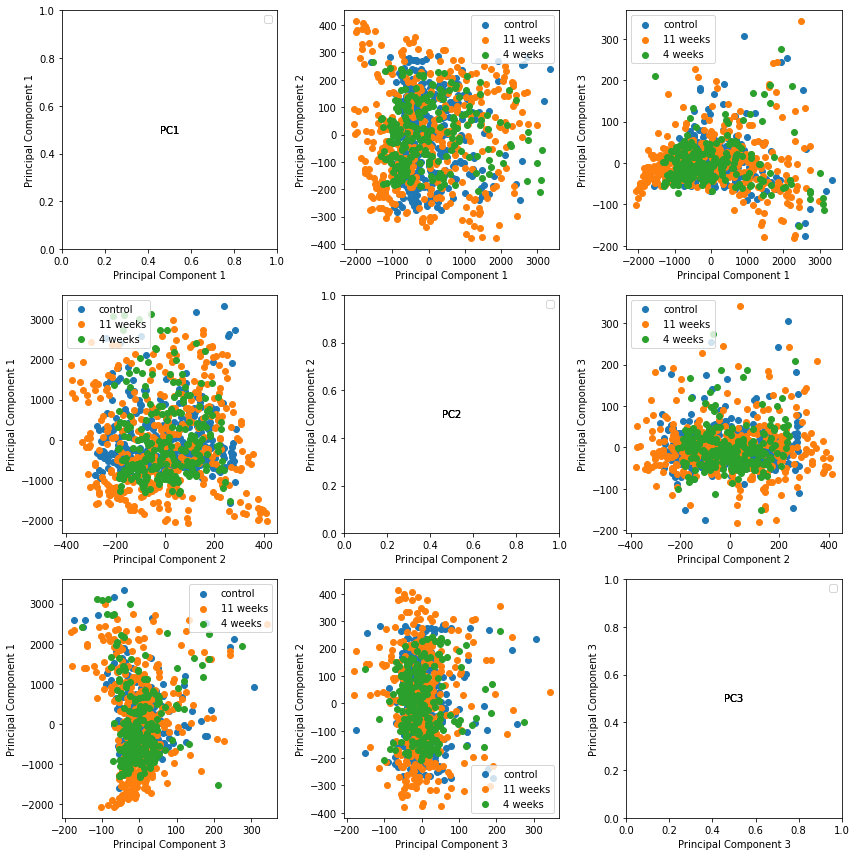

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def apply_and_plot_pca(csv_files_dict, n_components=3):
    """
    Apply PCA to multiple CSV files and plot pairwise plots of the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_dict: dict
        A dictionary where the keys are the labels and the values are the PCA results (numpy arrays).
    """

    pca = PCA(n_components=n_components)

    pca_results_dict = {}
    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])

        # Apply PCA
        pca_results = pca.fit_transform(numeric_columns)

        # Add the PCA results to the dictionary
        pca_results_dict[label] = pca_results

        # Print explained variance
        print(f"Explained variance ratio for {label}: {pca.explained_variance_ratio_}")

    # Create pairwise plots
    fig, axs = plt.subplots(n_components, n_components, figsize=(4*n_components, 4*n_components))

    for i in range(n_components):
        for j in range(n_components):
            for label, pca_results in pca_results_dict.items():
                if i != j:
                    axs[i, j].scatter(pca_results[:, i], pca_results[:, j], label=label)
                else:
                    axs[i, j].text(0.5, 0.5, f"PC{i+1}", ha="center", va="center")
                axs[i, j].set_xlabel(f'Principal Component {i+1}')
                axs[i, j].set_ylabel(f'Principal Component {j+1}')
                axs[i, j].legend()

    plt.tight_layout()
    plt.show()

    return pca_results_dict


# Define a dictionary of CSV files
csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}
pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio: [0.97119415 0.0250835 ]


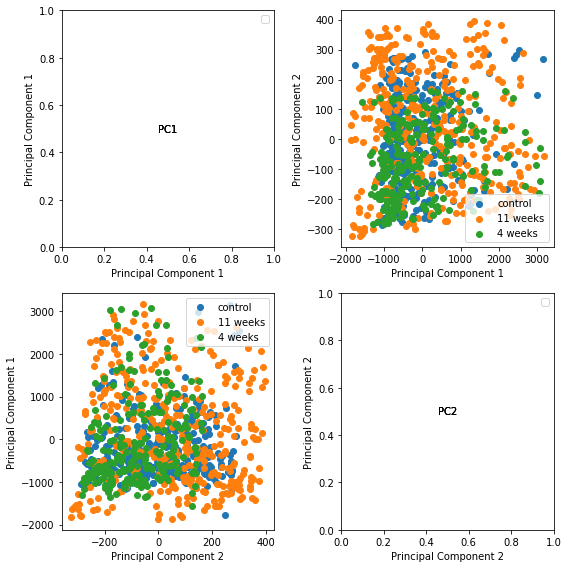

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def apply_and_plot_pca(csv_files_dict, n_components=3):
    """
    Apply PCA to multiple CSV files, concatenate the data, and plot pairwise plots of the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_dict: dict
        A dictionary where the keys are the labels and the values are the PCA results (numpy arrays).
    """
    
    concatenated_data = []
    label_index_ranges = {}

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        
        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(concatenated_data)

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Create pairwise plots
    fig, axs = plt.subplots(n_components, n_components, figsize=(4*n_components, 4*n_components))

    for i in range(n_components):
        for j in range(n_components):
            for label, (start_index, end_index) in label_index_ranges.items():
                if i != j:
                    axs[i, j].scatter(pca_results[start_index:end_index, i], pca_results[start_index:end_index, j], label=label)
                else:
                    axs[i, j].text(0.5, 0.5, f"PC{i+1}", ha="center", va="center")
                axs[i, j].set_xlabel(f'Principal Component {i+1}')
                axs[i, j].set_ylabel(f'Principal Component {j+1}')
                axs[i, j].legend()

    plt.tight_layout()
    plt.show()

    return pca_results


csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}
pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

     cell_id    cell_area  cell_volume  cell_isoperimetric_ratio  \
0         31  1086.617520  2055.977055                303.524381   
1         34   593.360103   938.110863                237.381405   
2         36   783.210900  1428.847045                235.323168   
3         38   922.351125  1984.205629                199.303759   
4         44  1753.049993  4128.660090                316.056441   
..       ...          ...          ...                       ...   
322      587   643.931195  1163.638481                197.188800   
323      588   703.663516  1224.766584                232.267500   
324      589   653.424930  1273.637545                171.986910   
325      590   955.519821  2017.158901                214.406960   
326      598   459.781482   792.590112                154.723802   

     cell_nb_of_neighbors  cell_elongation  cell_contact_area_fraction  \
0                      12         1.944479                    1.269156   
1                      12         1

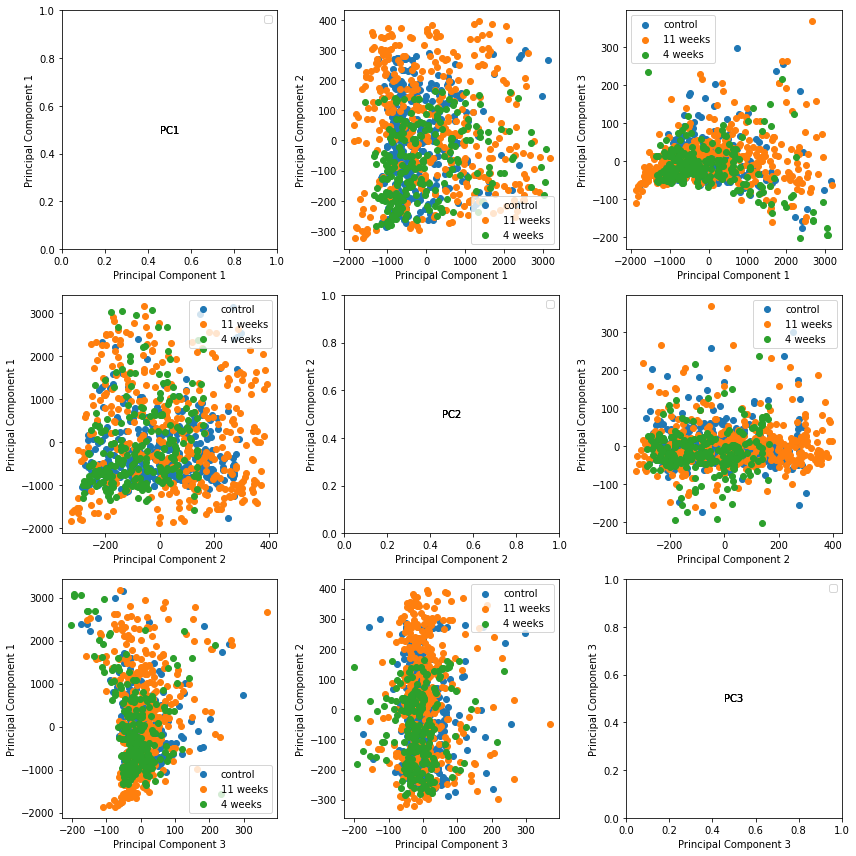

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def apply_and_plot_pca(csv_files_dict, n_components=3):
    """
    Apply PCA to multiple CSV files, concatenate the data, and plot pairwise plots of the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_dict: dict
        A dictionary where the keys are the labels and the values are the PCA results (numpy arrays).
    """
    
    concatenated_data = []
    label_index_ranges = {}

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        print(numeric_columns)
        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(concatenated_data)

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Print loadings (components)
    print(f"PCA loadings: \n{pca.components_}")

    # Create pairwise plots
    fig, axs = plt.subplots(n_components, n_components, figsize=(4*n_components, 4*n_components))

    for i in range(n_components):
        for j in range(n_components):
            for label, (start_index, end_index) in label_index_ranges.items():
                if i != j:
                    axs[i, j].scatter(pca_results[start_index:end_index, i], pca_results[start_index:end_index, j], label=label)
                else:
                    axs[i, j].text(0.5, 0.5, f"PC{i+1}", ha="center", va="center")
                axs[i, j].set_xlabel(f'Principal Component {i+1}')
                axs[i, j].set_ylabel(f'Principal Component {j+1}')
                axs[i, j].legend()

    plt.tight_layout()
    plt.show()

    return pca_results


csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Explained variance ratio: [0.97119415 0.0250835  0.00324416]
PCA loadings: 
[[-1.89746357e-02  3.09933422e-01  9.50268215e-01  1.38942412e-02
   2.05850405e-03  5.18652080e-05  5.49157025e-05  1.93459072e-02]
 [ 9.99566890e-01  2.24973599e-02  1.26499597e-02  1.05498767e-02
   2.01545363e-03 -1.41664201e-05  2.86498180e-05 -9.19331169e-03]
 [-2.01525650e-02  8.20156320e-01 -2.75522791e-01  5.00719072e-01
   1.06081278e-02  2.13097169e-03  2.00812228e-04  1.37103128e-02]]


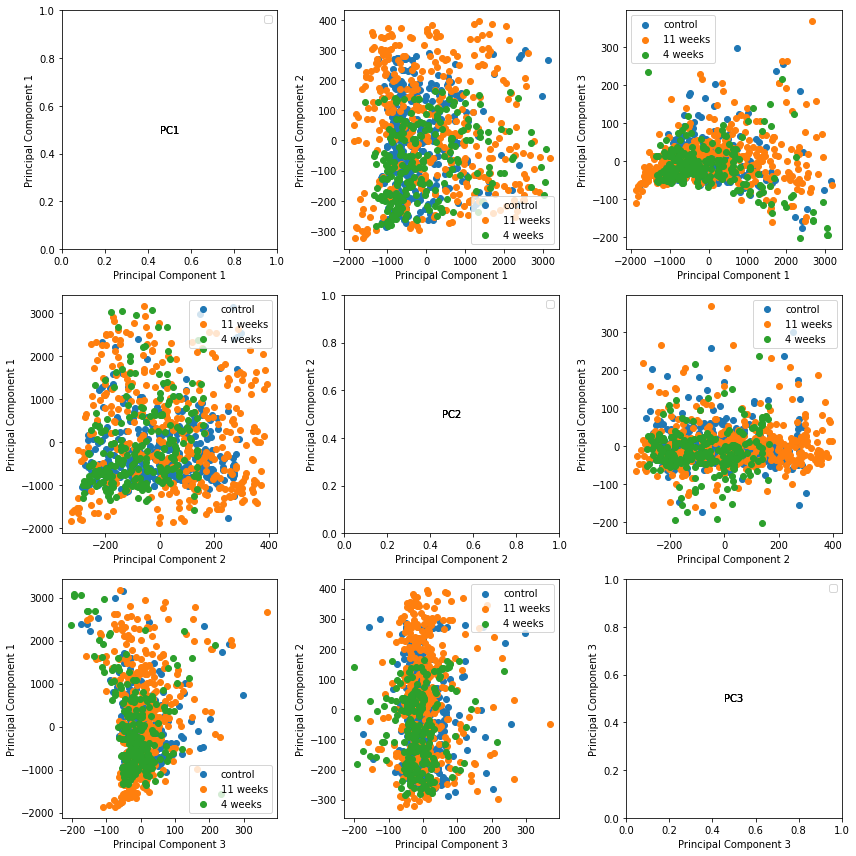

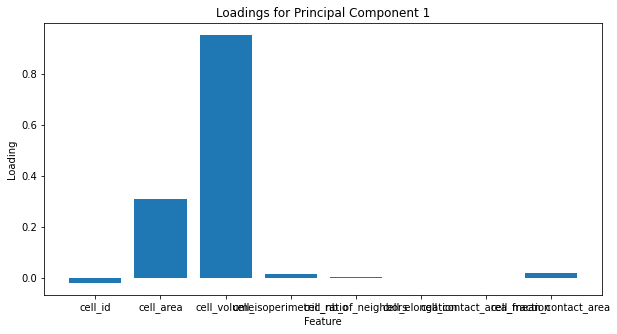

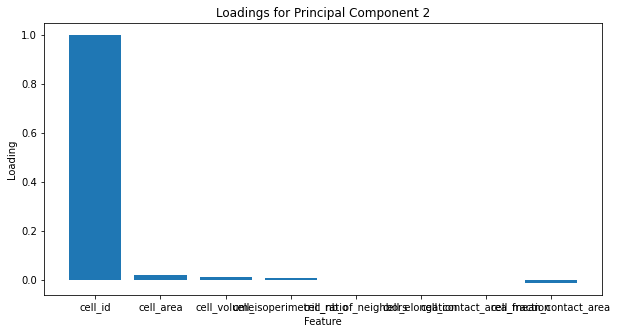

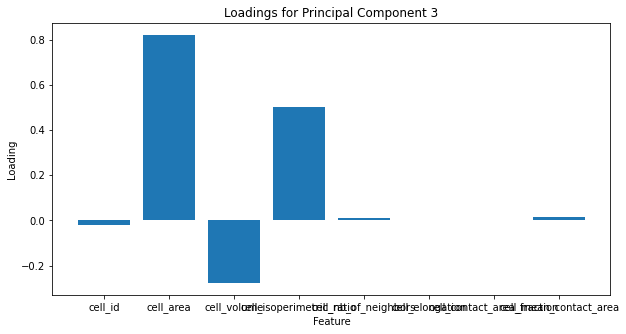

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def apply_and_plot_pca(csv_files_dict, n_components=3):
    """
    Apply PCA to multiple CSV files, concatenate the data, and plot pairwise plots of the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_dict: dict
        A dictionary where the keys are the labels and the values are the PCA results (numpy arrays).
    """
    
    concatenated_data = []
    label_index_ranges = {}
    feature_names = None

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        
        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the feature names
        if feature_names is None:
            feature_names = numeric_columns.columns.tolist()

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(concatenated_data)

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Print loadings (components)
    print(f"PCA loadings: \n{pca.components_}")

    # Create pairwise plots
    fig, axs = plt.subplots(n_components, n_components, figsize=(4*n_components, 4*n_components))

    for i in range(n_components):
        for j in range(n_components):
            for label, (start_index, end_index) in label_index_ranges.items():
                if i != j:
                    axs[i, j].scatter(pca_results[start_index:end_index, i], pca_results[start_index:end_index, j], label=label)
                else:
                    axs[i, j].text(0.5, 0.5, f"PC{i+1}", ha="center", va="center")
                axs[i, j].set_xlabel(f'Principal Component {i+1}')
                axs[i, j].set_ylabel(f'Principal Component {j+1}')
                axs[i, j].legend()

    plt.tight_layout()
    plt.show()

    # Plot loadings
    for i in range(n_components):
        plt.figure(figsize=(10, 5))
        loadings = pca.components_[i]
        plt.bar(feature_names, loadings)
        plt.title(f"Loadings for Principal Component {i+1}")
        plt.xlabel("Feature")
        plt.ylabel("Loading")
        plt.show()

    return pca_results

csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio: [0.54653717 0.19194575]
PCA loadings: 
[[ 0.49030889  0.46979603  0.31437127  0.38587056  0.24961392  0.26984078
   0.39502195]
 [-0.06302921 -0.15247862  0.57256579 -0.20674444  0.63968036 -0.42601715
  -0.10733665]]


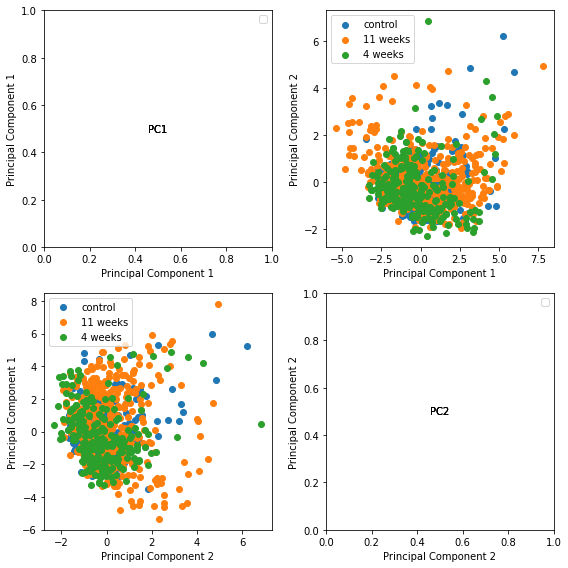

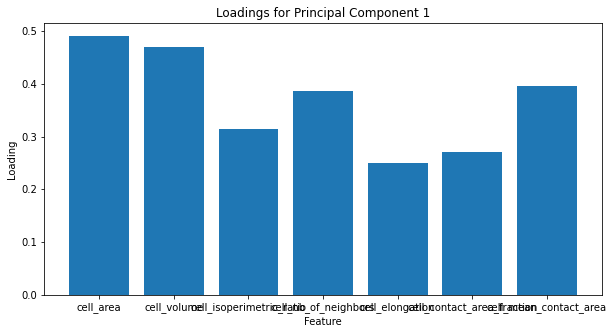

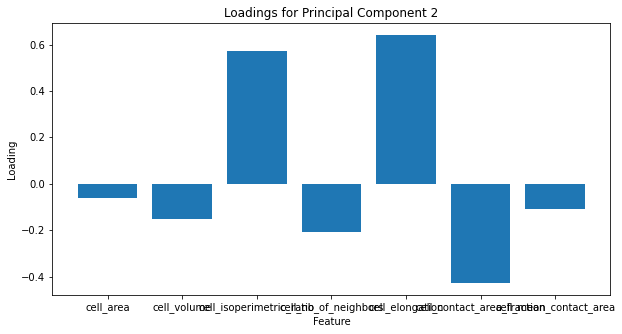

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def apply_and_plot_pca(csv_files_dict, n_components=3):
    """
    Apply PCA to multiple CSV files, concatenate the data, and plot pairwise plots of the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_dict: dict
        A dictionary where the keys are the labels and the values are the PCA results (numpy arrays).
    """

    concatenated_data = []
    label_index_ranges = {}
    feature_names = None

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        numeric_columns = numeric_columns.drop('cell_id', axis=1)

        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the feature names
        if feature_names is None:
            feature_names = numeric_columns.columns.tolist()

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(concatenated_data)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(scaled_data)

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Print loadings (components)
    print(f"PCA loadings: \n{pca.components_}")

    # Create pairwise plots
    fig, axs = plt.subplots(n_components, n_components, figsize=(4*n_components, 4*n_components))

    for i in range(n_components):
        for j in range(n_components):
            for label, (start_index, end_index) in label_index_ranges.items():
                if i != j:
                    axs[i, j].scatter(pca_results[start_index:end_index, i], pca_results[start_index:end_index, j], label=label)
                else:
                    axs[i, j].text(0.5, 0.5, f"PC{i+1}", ha="center", va="center")
                axs[i, j].set_xlabel(f'Principal Component {i+1}')
                axs[i, j].set_ylabel(f'Principal Component {j+1}')
                axs[i, j].legend()

    plt.tight_layout()
    plt.show()

    # Plot loadings
    for i in range(n_components):
        plt.figure(figsize=(10, 5))
        loadings = pca.components_[i]
        plt.bar(feature_names, loadings)
        plt.title(f"Loadings for Principal Component {i+1}")
        plt.xlabel("Feature")
        plt.ylabel("Loading")
        plt.show()

    return pca_results

csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio: [0.54653717 0.19194575]
PCA loadings: 
[[ 0.49030889  0.46979603  0.31437127  0.38587056  0.24961392  0.26984078
   0.39502195]
 [-0.06302921 -0.15247862  0.57256579 -0.20674444  0.63968036 -0.42601715
  -0.10733665]]


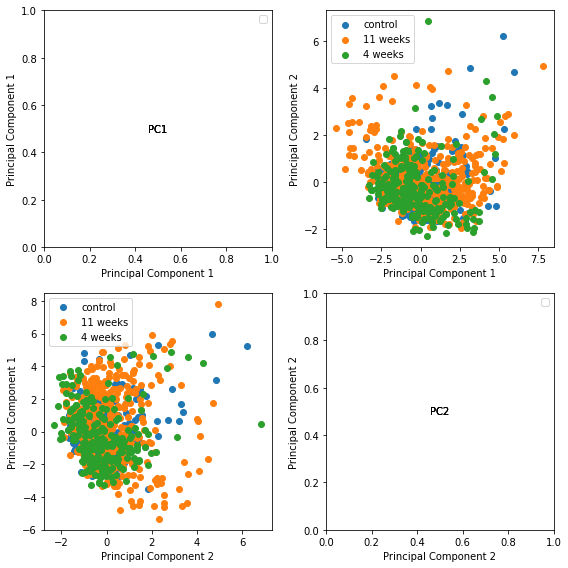

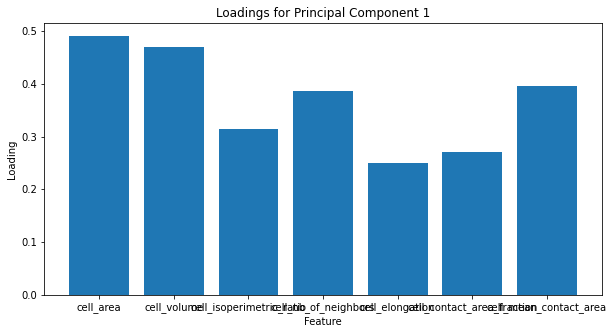

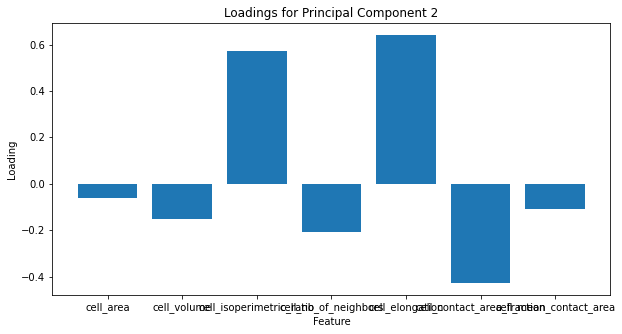

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_and_plot_pca_seaborn(csv_files_dict, n_components=3):
    """
    Apply PCA to multiple CSV files, concatenate the data, and plot pairwise plots of the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    n_components: int, optional
        The number of principal components to keep.

    Returns:
    --------
    pca_results_df: DataFrame
        A DataFrame where the rows correspond to samples and the columns to the PCA results.
    """

    concatenated_data = []
    labels = []
    feature_names = None

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        numeric_columns = numeric_columns.drop('cell_id', axis=1)

        concatenated_data.extend(numeric_columns.values)
        labels.extend([label]*len(numeric_columns))

        # Save the feature names
        if feature_names is None:
            feature_names = numeric_columns.columns.tolist()

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(concatenated_data)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(scaled_data)

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Print loadings (components)
    print(f"PCA loadings: \n{pca.components_}")

    # Convert PCA results to a DataFrame and add labels
    pca_results_df = pd.DataFrame(pca_results, columns=[f"PC{i+1}" for i in range(n_components)])
    pca_results_df['Label'] = labels

    # Create pairwise plots with Seaborn
    sns.pairplot(pca_results_df, hue="Label", diag_kind="hist")

    # Plot loadings
    for i in range(n_components):
        plt.figure(figsize=(10, 5))
        loadings = pca.components_[i]
        sns.barplot(x=feature_names, y=loadings)
        plt.title(f"Loadings for Principal Component {i+1}")
        plt.xlabel("Feature")
        plt.ylabel("Loading")
        plt.show()

    return pca_results_df

csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_pca(csv_files_dict, n_components=2)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 923 samples in 0.000s...
[t-SNE] Computed neighbors for 923 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 923 / 923
[t-SNE] Mean sigma: 0.396279
[t-SNE] KL divergence after 250 iterations with early exaggeration: 416.760529
[t-SNE] KL divergence after 2000 iterations: 1.043822


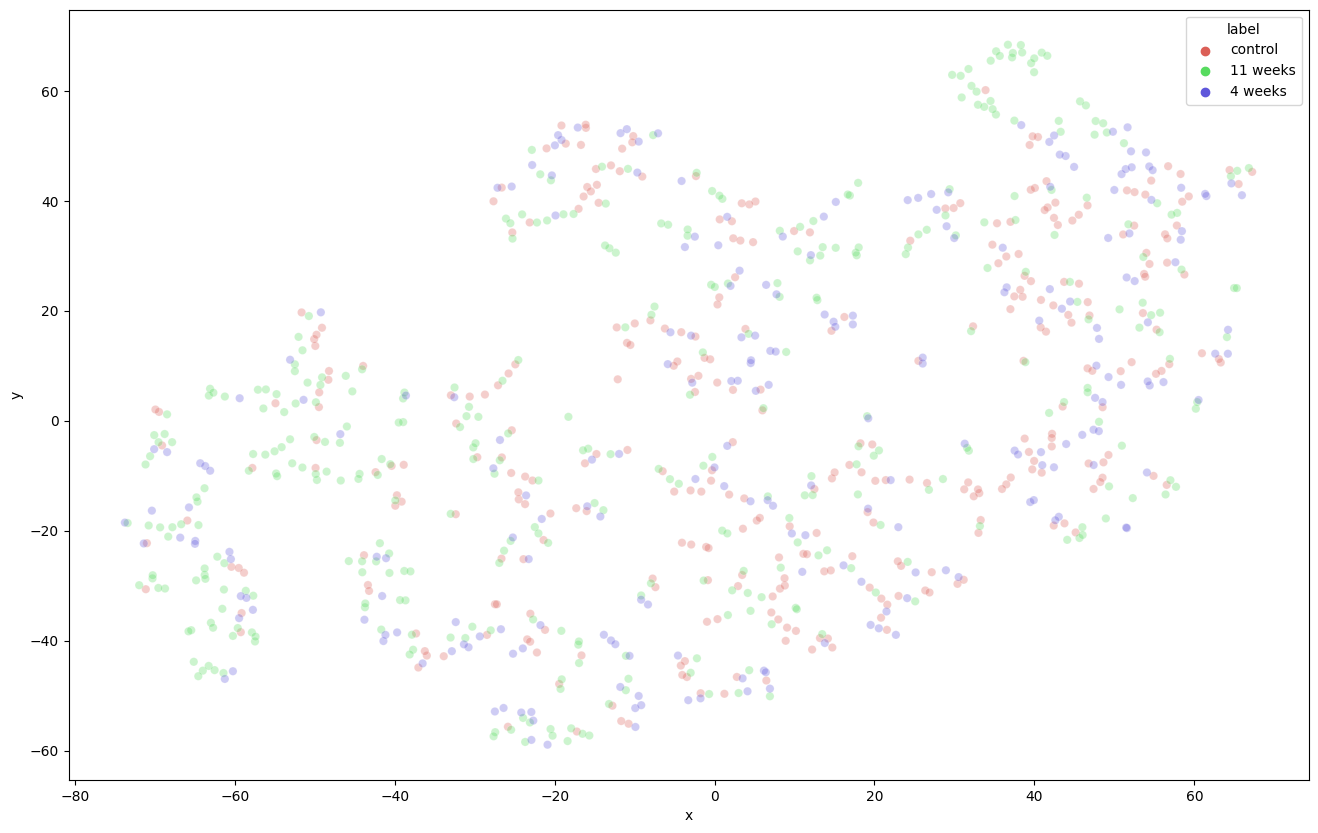

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def apply_and_plot_tsne(csv_files_dict):
    """
    Apply t-SNE to multiple CSV files, concatenate the data, and plot the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    Returns:
    --------
    tsne_results_dict: dict
        A dictionary where the keys are the labels and the values are the t-SNE results (numpy arrays).
    """

    concatenated_data = []
    label_index_ranges = {}
    feature_names = None
    labels = []

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        numeric_columns = numeric_columns.drop('cell_id', axis=1)

        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the feature names
        if feature_names is None:
            feature_names = numeric_columns.columns.tolist()

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

        # Add labels for each row
        labels.extend([label] * numeric_columns.shape[0])

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(concatenated_data)

    # Apply t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=10, early_exaggeration=50, n_iter=2000, init = 'pca')
    tsne_results = tsne.fit_transform(scaled_data)

    # Create DataFrame for seaborn plot
    df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
    df_tsne['label'] = labels

    # Plot t-SNE results with seaborn
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        palette=sns.color_palette("hls", len(csv_files_dict)),
        data=df_tsne,
        legend="full",
        alpha=0.3
    )

    return tsne_results

csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_tsne(csv_files_dict)

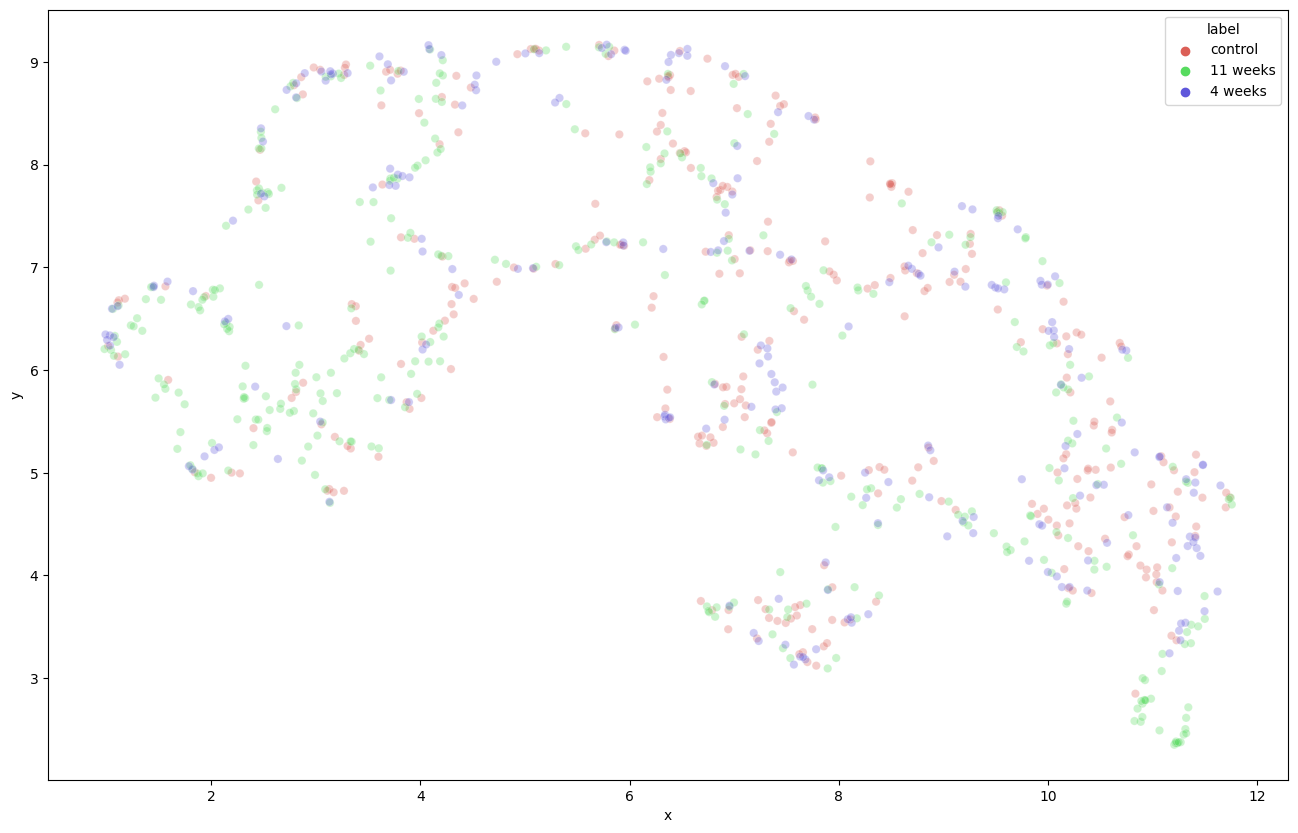

In [ ]:
import umap 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_and_plot_umap(csv_files_dict):
    """
    Apply UMAP to multiple CSV files, concatenate the data, and plot the results with different colors.

    Parameters:
    -----------
    csv_files_dict: dict
        A dictionary where the keys are labels for the data sets and the values are the paths to the CSV files.

    Returns:
    --------
    umap_results_dict: dict
        A dictionary where the keys are the labels and the values are the UMAP results (numpy arrays).
    """

    concatenated_data = []
    label_index_ranges = {}
    feature_names = None
    labels = []

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        numeric_columns = numeric_columns.drop('cell_id', axis=1)

        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the feature names
        if feature_names is None:
            feature_names = numeric_columns.columns.tolist()

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

        # Add labels for each row
        labels.extend([label] * numeric_columns.shape[0])

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(concatenated_data)

    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=10, repulsion_strength=0.9, min_dist=0.1, spread = 1)
    umap_results = reducer.fit_transform(scaled_data)

    # Create DataFrame for seaborn plot
    df_umap = pd.DataFrame(umap_results, columns=['x', 'y'])
    df_umap['label'] = labels

    # Plot UMAP results with seaborn
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        palette=sns.color_palette("hls", len(csv_files_dict)),
        data=df_umap,
        legend="full",
        alpha=0.3
    )

    return umap_results

csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_umap(csv_files_dict)

May 25 03:30:20 PM: Computing 10-nearest neighbors, with max_distance=None
May 25 03:30:20 PM: Exact nearest neighbors by brute force 


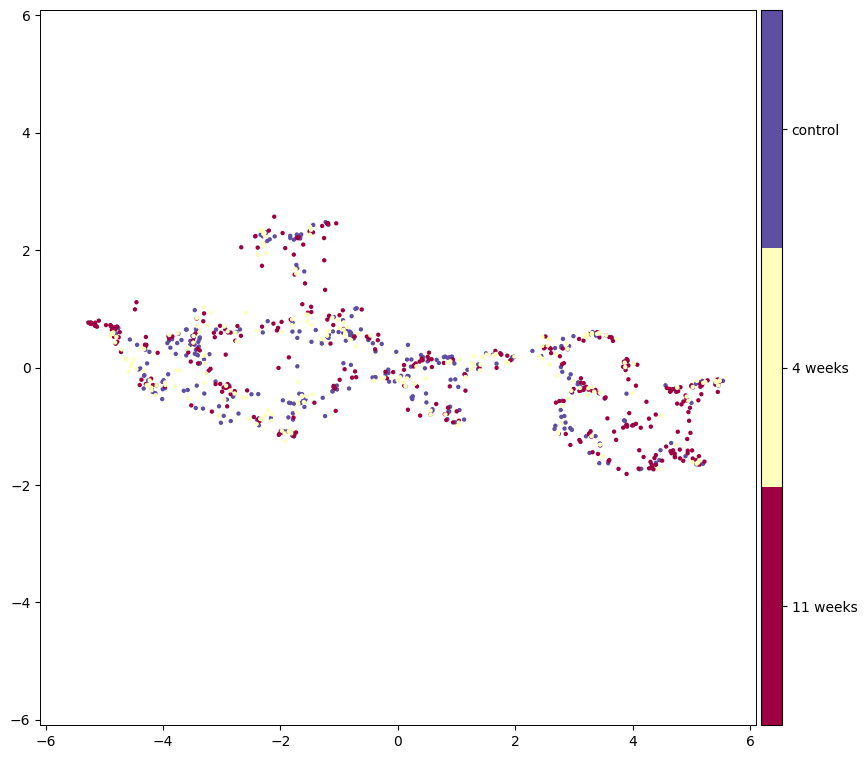

In [ ]:
import pymde
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def apply_and_plot_pymde(csv_files_dict):
    """
    Apply MDE to multiple pandas DataFrames, concatenate the data, and plot the results with different colors.

    Parameters:
    -----------
    data_dict: dict
        A dictionary where the keys are labels for the data sets and the values are pandas dataframes.

    Returns:
    --------
    mde_results_dict: dict
        A dictionary where the keys are the labels and the values are the MDE results (numpy arrays).
    """

    concatenated_data = []
    label_index_ranges = {}
    feature_names = None
    labels = []

    for label, csv_file in csv_files_dict.items():
        # Load the data from the CSV file
        data_df = pd.read_csv(csv_file)

        # Get the numeric columns
        numeric_columns = data_df.select_dtypes(include=[np.number])
        numeric_columns = numeric_columns.drop('cell_id', axis=1)

        start_index = len(concatenated_data)
        concatenated_data.extend(numeric_columns.values)
        end_index = len(concatenated_data)

        # Save the feature names
        if feature_names is None:
            feature_names = numeric_columns.columns.tolist()

        # Save the start and end indices for each label
        label_index_ranges[label] = (start_index, end_index)

        # Add labels for each row
        labels.extend([label] * numeric_columns.shape[0])

    # Convert the list to a numpy array
    concatenated_data = np.array(concatenated_data)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(concatenated_data)

    # Apply MDE
    embedding = pymde.preserve_neighbors(scaled_data, n_neighbors = 10, embedding_dim=2, verbose=True, init = 'random', repulsive_penalty = pymde.penalties.InvPower).embed()
    #embedding = pymde.preserve_distances(scaled_data).embed()

    # Plot MDE results
    pymde.plot(embedding, color_by=labels, marker_size=10)

    return embedding
csv_files_dict = {
    'control': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_Control_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '11 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_11w_s_10_e_2_d_3/filtered_cell_statistics.csv',
    '4 weeks': '/Users/antanas/BC_Project/No_Edge_5000/No_edge/Validated_labels_Franzi_4w_s_10_e_2_d_3/filtered_cell_statistics.csv'
}

pca_results_dict = apply_and_plot_pymde(csv_files_dict)